In [31]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from scipy.spatial import distance
from sklearn import manifold
from rdkit.Chem.SaltRemover import SaltRemover

from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

import matplotlib.pyplot as plt

In [4]:
supp = Chem.SDMolSupplier("../data/drugbank.sdf")
drugbank = [mol for mol in supp if mol]

In [5]:
drugbank = drugbank[0:500]
len(drugbank)

500

In [6]:
fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for m in drugbank]

In [7]:
sparce_mat = distance.pdist(fps, metric="jaccard")

In [8]:
dist_mat = distance.squareform(sparce_mat)

In [9]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [10]:
X_mds[0,0]

0.28287531158857065

In [11]:
def mds_plot(X, *args, highlights=set()):
    plt.figure()
    ax = plt.subplot(111)
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x], [y], "r.", markersize=4)
        else:
            plt.plot([x], [y], "k.", markersize=1)
    plt.show()

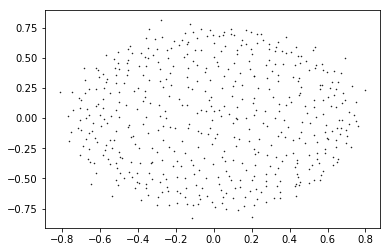

In [12]:
mds_plot(X_mds)

In [13]:
pattern = Chem.MolFromSmiles('c1ccccc1')
pat_idxs = [i for i, mol in enumerate(drugbank) if mol.HasSubstructMatch(pattern)]

In [14]:
len(pat_idxs)

298

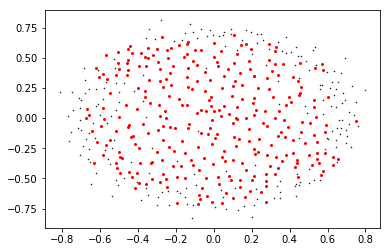

In [15]:
mds_plot(X_mds, highlights=set(pat_idxs))

In [18]:
1-dist_mat[pat_idxs,:][:,pat_idxs]

array([[ 1.        ,  0.37106918,  0.40714286, ...,  0.12977099,
         0.12598425,  0.07194245],
       [ 0.37106918,  1.        ,  0.30625   , ...,  0.11888112,
         0.13138686,  0.08783784],
       [ 0.40714286,  0.30625   ,  1.        , ...,  0.1300813 ,
         0.08943089,  0.06060606],
       ..., 
       [ 0.12977099,  0.11888112,  0.1300813 , ...,  1.        ,
         0.1038961 ,  0.08333333],
       [ 0.12598425,  0.13138686,  0.08943089, ...,  0.1038961 ,
         1.        ,  0.1025641 ],
       [ 0.07194245,  0.08783784,  0.06060606, ...,  0.08333333,
         0.1025641 ,  1.        ]])

In [20]:
Draw.MolsToGridImage([mol for i,mol in enumerate(drugbank) if i in pat_idxs])

ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 72 74


In [21]:
def distance_function(index1, index2, *args, matrix=dist_mat):
    return matrix[index1,index2]

picker = MaxMinPicker()
picked_gen = picker.LazyPick(distance_function, len(drugbank), 100, seed=666) 
picked = set(picked_gen)

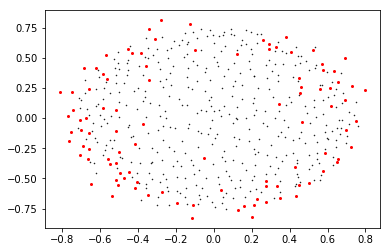

In [22]:
mds_plot(X_mds, highlights=picked)

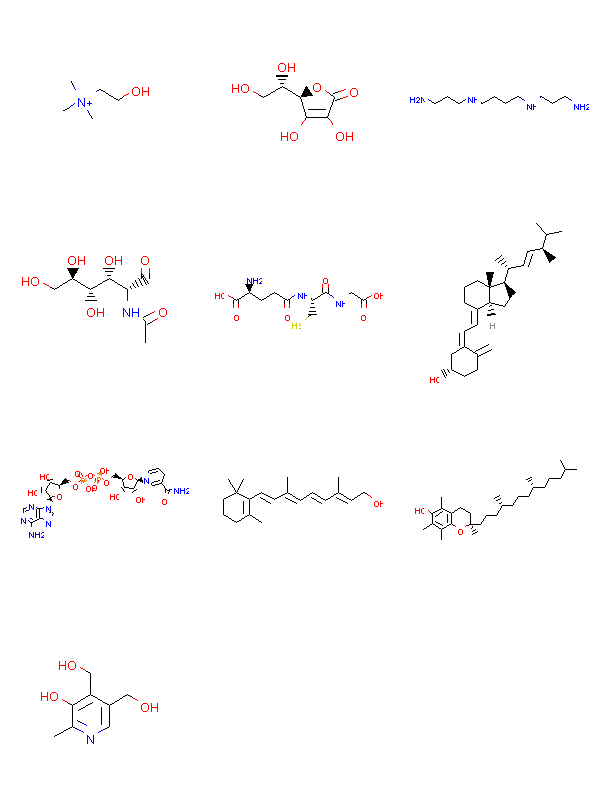

In [23]:
Draw.MolsToGridImage([mol for i, mol in enumerate(drugbank) if i in picked][:10])

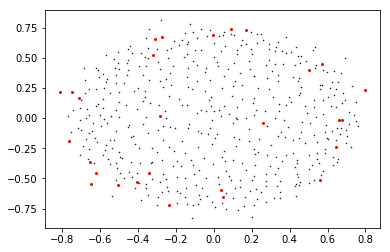

In [27]:
carbon_pat = Chem.MolFromSmarts("[#6]")
non_carbon_pat = Chem.MolFromSmarts("[!C;!c;!#7;!#8;!#16;!Cl;!F;!Br;!I]")
carb_idxs = [i for i, mol in enumerate(drugbank) if mol.HasSubstructMatch(carbon_pat)]
noncarb_idxs = [i for i, mol in enumerate(drugbank) if mol.HasSubstructMatch(non_carbon_pat)]
mds_plot(X_mds,highlights=set(noncarb_idxs))

In [28]:
Draw.MolsToGridImage([mol for i, mol in enumerate(drugbank) if i in noncarb_idxs][:2])

ValueError: Sanitization error: Can't kekulize mol.  Unkekulized atoms: 65 66 67 68 69 72 74


In [34]:
remover = SaltRemover(defnData='[!C;!c;!#7;!#8;!#16;!Cl;!F;!Br;!I]')
remover = SaltRemover()

In [35]:
mol = Chem.MolFromSmiles("[K+].[Cl-]") 
Chem.MolToSmiles(remover(mol))

''